In [21]:
import torch
import numpy as np
import cv2
import os
from dataset import HelicopterUAV,HelicopterSatellite,BuildTransforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from models import build_model
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from PIL import Image

# Load satellite images

In [31]:
root_dir="G:/DATASET/round2/Val"
uav_images=os.listdir(os.path.join(root_dir,"query_images"))
satellite_images=os.listdir(os.path.join(root_dir,"reference_images/offset_0_None"))
batch_size=8
transform=BuildTransforms(256)
# uav_dataset=HelicopterUAV(root_dir,False, transform)
satellite_dataset=HelicopterSatellite(root_dir,False, transform)
#
# uav_dataloader= DataLoader(uav_dataset,batch_size=batch_size)
satellite_dataloader= DataLoader(satellite_dataset,batch_size=batch_size)

gt=np.loadtxt(os.path.join(root_dir,"gt_matches.csv"),delimiter=',',dtype=str)[1:,:]

## Build model
Alexnet

In [5]:
model_name="alexnet_triplet"
model=build_model(model_name,dropout_p=False).cuda()

Successfully loaded imagenet pretrained weights from "C:\Users\wangerniu/.cache\torch\checkpoints\alexnet-owt-7be5be79.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias']


# Extract features

In [6]:
def ExtractFeature(model, Dataloader):
    model.eval()
    drone_name = []
    with torch.no_grad():
        for batch_idx, (image, name), in enumerate(tqdm(Dataloader)):
            image = image.cuda()
            v1 = model(image)
            # v1= nn.functional.normalize(v1, p=2, dim=1)
            if batch_idx == 0:
                drone_feature = v1
            else:
                drone_feature = torch.cat([drone_feature, v1], dim=0)
            drone_name.extend(name)
    return drone_name,drone_feature

### Save satellite features

In [8]:
save_path="features"
satellite_feature_file='satellite_feature.npy'

satellite_feature_path=os.path.join(save_path, satellite_feature_file)

if os.path.exists(satellite_feature_path):
    print("Existing...")
    satellite_feature =np.load(satellite_feature_path)
else:
    print("ExtractFeature。。。")
    satellite_name,satellite_feature =ExtractFeature(model,satellite_dataloader)
    satellite_feature=satellite_feature.cpu().numpy()
    np.save(os.path.join(save_path, satellite_feature_file), satellite_feature)

Existing...


# Image sort

In [9]:
def manifold(feature,n_neighbors=5):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=1, p=2)
    result = isomap.fit_transform(feature)
    return result

In [13]:
satellite_result=manifold(satellite_feature)#Dimension-reduced features
print(satellite_result.shape)

(459, 1)


# Visualization

In [16]:
satellite_rank=np.argsort(satellite_result[:,0])#Satellite sort result
satellite_rank

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

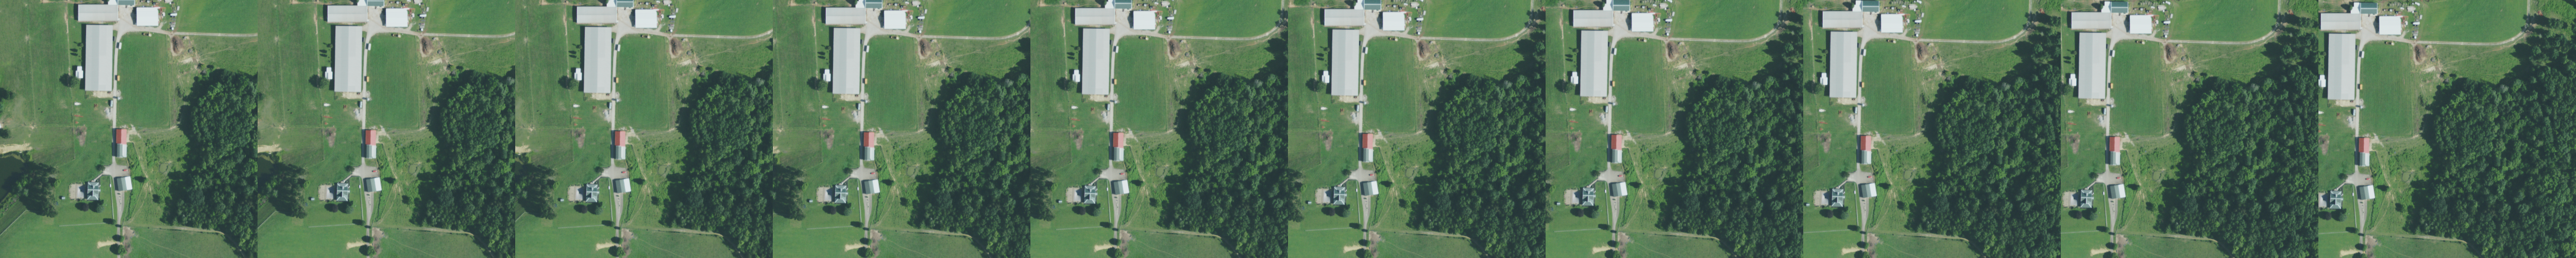

In [24]:
Vis_10_images=[]
for i in range(10):
    satellite_index=satellite_rank[i]
    satellite_bgr=cv2.imread(os.path.join(root_dir,"reference_images/offset_0_None",satellite_images[satellite_index]))
    Vis_10_images.append(satellite_bgr)
Vis_10_images=np.hstack(Vis_10_images)
Image.fromarray(cv2.cvtColor(Vis_10_images,cv2.COLOR_BGR2RGB))

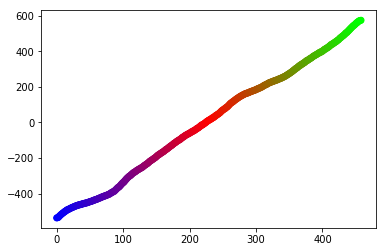

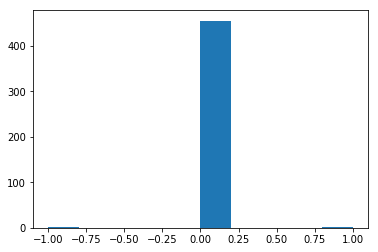

Sorting error: 0.008714596949891068


In [14]:
satellite_rank_true=range(satellite_result.shape[0])
plt.scatter(satellite_rank_true,satellite_result, c=satellite_rank_true, cmap='brg')
plt.show()

erro=satellite_rank-satellite_rank_true#Sorting error
num_bins = 10
plt.hist(erro, num_bins)#Error histogram
plt.show()
print("Sorting error:",np.mean(abs(erro)))

# Image matching
LoFTR

In [25]:
from match.src.loftr import LoFTR, default_cfg

In [26]:
#https://github.com/zju3dv/LoFTR
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("match/weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [32]:
def eq(m, n):#平均距离
    return np.sqrt(np.sum((m - n) ** 2))
def frame2tensor(frame):
    return torch.from_numpy(frame/255.).float()[None, None].cuda()

Pointer=0#指针,指向下一次可能出现的位置
results_info=[]#实验结果保存
history_predict=[]#历史定位信息

for uav_index in range(len(uav_images)):#对于每个无人机图像
    info=[]
    matchinfo=[]
    uav_path=uav_images[uav_index]
    #gt
    _,_,true_id,_,_=gt[uav_index]
    #read UAV images
    uav_gray=cv2.imread(os.path.join(root_dir,"query_images",uav_path),0)
    uav_gray=cv2.resize(uav_gray,(256,256))
    uav_image_tensor=frame2tensor(uav_gray)
    #取局部卫星图像
    if Pointer>=10:
        local_search=satellite_rank[Pointer-10:Pointer+10]
    else:
        local_search=satellite_rank[0:Pointer+10]

    local_distance=[]
    for satellite_index in local_search:
        satellite_gray=cv2.imread(os.path.join(root_dir,"reference_images/offset_0_None",satellite_images[satellite_index]),0)
        satellite_gray=cv2.resize(satellite_gray,(256,256))
        satellite_image_tensor=frame2tensor(satellite_gray)

        batch={}
        batch['image0']=uav_image_tensor
        batch['image1']=satellite_image_tensor

        # Inference
        with torch.no_grad():
            matcher(batch)    # batch = {'image0': img0, 'image1': img1}
            mkpts0 = batch['mkpts0_f'].cpu().numpy()
            mkpts1 = batch['mkpts1_f'].cpu().numpy()
        M, mask = cv2.findHomography(mkpts0,mkpts1, cv2.RANSAC, 3)#Homography
        mkpts0,mkpts1=mkpts0[np.where(mask[:,0]==1)],mkpts1[np.where(mask[:,0]==1)]

        img1_dims = np.float32([[128, 128]]).reshape(-1, 1, 2)
        # img2_dims = np.float32([[178, 178]]).reshape(-1, 1, 2)
        img1_transform = cv2.perspectiveTransform(img1_dims, M)[0][0]
        # img2_transform = cv2.perspectiveTransform(img2_dims, M)[0][0]
        distance=eq(img1_transform,[128, 128])#offset
        local_distance.append(distance)
    pridict_local_id=np.argmin(local_distance)

    info="UAV ID:{},Ture ID:{},Global ID:{},Distance:{}".format(uav_index,true_id,local_search[pridict_local_id],local_distance[pridict_local_id])
    print(info)
    Pointer=local_search[pridict_local_id]+1
    history_predict.append(Pointer)
    results_info.append([uav_index,true_id,local_search[pridict_local_id],local_distance[pridict_local_id]])

UAV ID:0,Ture ID:0,Global ID:0,Distance:5.993135249276421
UAV ID:1,Ture ID:0,Global ID:0,Distance:5.340580654033415
UAV ID:2,Ture ID:1,Global ID:0,Distance:5.224265277997669
UAV ID:3,Ture ID:1,Global ID:0,Distance:5.528034769648758
UAV ID:4,Ture ID:1,Global ID:1,Distance:5.278810924786745
UAV ID:5,Ture ID:1,Global ID:1,Distance:5.806278405197666
UAV ID:6,Ture ID:2,Global ID:1,Distance:5.073990533067993
UAV ID:7,Ture ID:2,Global ID:2,Distance:7.162331262637086
UAV ID:8,Ture ID:2,Global ID:2,Distance:5.99187132601359
UAV ID:9,Ture ID:2,Global ID:2,Distance:4.640742866242935
UAV ID:10,Ture ID:3,Global ID:2,Distance:5.6565770482285895
UAV ID:11,Ture ID:3,Global ID:2,Distance:7.270962029225449
UAV ID:12,Ture ID:3,Global ID:3,Distance:5.300171956448325
UAV ID:13,Ture ID:3,Global ID:3,Distance:5.796387204168078
UAV ID:14,Ture ID:4,Global ID:3,Distance:5.156528797929927
UAV ID:15,Ture ID:4,Global ID:4,Distance:6.087725831611977
UAV ID:16,Ture ID:4,Global ID:4,Distance:5.24664104529661
UAV ID:1

# Save results

In [39]:
results_path="results_out.csv"
if os.path.exists(results_path):
    results_out=np.loadtxt(results_path,delimiter=',',dtype=str)
    results_out=np.array(results_out)
else:
    results_out=[["UAV ID","Ture ID","Predict ID","Distance"]]
    results_out.extend(results_info)
    results_out=np.array(results_out)
    np.savetxt("results_out.csv",results_out,delimiter=',',fmt="%s")